In [216]:
%load_ext autoreload
%autoreload 2

import torch
from circuits_benchmark.utils.get_cases import get_cases
import iit.model_pairs as mp
from circuits_benchmark.utils.ll_model_loader.ll_model_loader_factory import get_ll_model_loader
from circuits_benchmark.benchmark.benchmark_case import BenchmarkCase
import os


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [217]:
from interp_utils.node_stats.all_stats import get_all_stats_for_model_pair

### Make Node Stats for case

In [ ]:
task_idx = '4'
out_dir = f'results/{task_idx}/node_stats'
os.makedirs(out_dir, exist_ok=True)

task: BenchmarkCase = get_cases(indices=[task_idx])[0]

ll_model_loader = get_ll_model_loader(task, interp_bench=True)
hl_ll_corr, model = ll_model_loader.load_ll_model_and_correspondence(device='cuda' if torch.cuda.is_available() else 'cpu')
# turn off grads
model.eval()
model.requires_grad_(False)

hl_model = task.get_hl_model()
model_pair = mp.StrictIITModelPair(hl_model, model, hl_ll_corr)
max_len = 1000
unique_test_data = task.get_clean_data(max_samples=max_len, unique_data=True)
loader = torch.utils.data.DataLoader(unique_test_data, batch_size=256, shuffle=False, drop_last=False)

In [310]:
combined_df = get_all_stats_for_model_pair(model_pair, loader, task)

100%|██████████| 4/4 [00:00<00:00, 21.72it/s]
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [311]:
from interp_utils.node_stats.plotting import plot_cache
plot_cache(task_name=task.get_name(), cache_df=combined_df, cache_type="norm")

In [313]:
# plot_cache(task.get_name(), combined_df, "grad", x="norm_cache")

In [314]:
# from circuits_benchmark.utils.iit.correspondence import TracrCorrespondence
# natural_model_loader = get_ll_model_loader(task, interp_bench=False, natural=True, load_from_wandb=True)
# hl_ll_corr, natural_model = natural_model_loader.load_ll_model_and_correspondence(device='cuda' if torch.cuda.is_available() else 'cpu')
# model_pair = mp.StrictIITModelPair(hl_model, natural_model, hl_ll_corr)
# natural_model_combined_df = get_all_stats_for_model_pair(model_pair, loader, task)
# natural_model_combined_df["status"] = "not_in_circuit"

In [315]:
# plot_cache(task.get_name(), natural_model_combined_df, "grad", x="norm_cache")

### All cases

In [68]:
from circuits_benchmark.utils.get_cases import get_names_of_working_cases
from circuits_benchmark.utils.iit.iit_hl_model import IITHLModel

working_cases = get_names_of_working_cases()
remove_cases = ["ioi", "ioi_next_token"]
working_cases = [case for case in working_cases if case not in remove_cases]
working_cases = get_cases(indices=working_cases)

In [ ]:
from interp_utils.node_stats.all_stats import make_all_stats

all_stats = make_all_stats(cases=working_cases)

In [82]:
def get_tracr_stats(all_stats, kl = False):
    tracr_stats = {}
    for case in working_cases:
        if kl and not case.is_categorical():
            continue
        if case.get_name() not in all_stats:
            continue
        case_name = case.get_name()
        tracr_model_loader = get_ll_model_loader(case, tracr=True)
        corr, tracr_ll_model = tracr_model_loader.load_ll_model_and_correspondence(device='cuda' if torch.cuda.is_available() else 'cpu')
        tracr_model_pair = mp.StrictIITModelPair(case.get_hl_model(), tracr_ll_model, corr)
        dataset = case.get_clean_data(max_samples=2000)
        loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=False, drop_last=False)
        tracr_combined_df = get_all_stats_for_model_pair(tracr_model_pair, loader, case)
        tracr_stats[case_name] = tracr_combined_df
    return tracr_stats

In [ ]:
tracr_stats = get_tracr_stats(all_stats)

In [83]:
assert tracr_stats.keys() == all_stats.keys()

In [307]:
from interp_utils.node_stats.plotting import plot_keys_plotly
# plot_keys_plotly(all_stats, x="norm_cache", y="grad_norm", yerr="grad_std")

In [306]:
# plot_keys_plotly(all_stats, x="grad_norm", y="norm_cache", yerr="norm_std")

In [308]:
plot_keys_plotly(
    all_stats, 
    x = "zero_ablate_effect",
    y = "norm_cache",
    yerr = "norm_std",
    xlog=False,
    ylog=True,
    cases=None
)

In [318]:
plot_keys_plotly(
    all_stats, 
    x = "zero_ablate_effect",
    y = "grad_norm",
    yerr = "grad_std",
    xlog=False,
    ylog=True,
    cases=None
)

### All Cases node effects

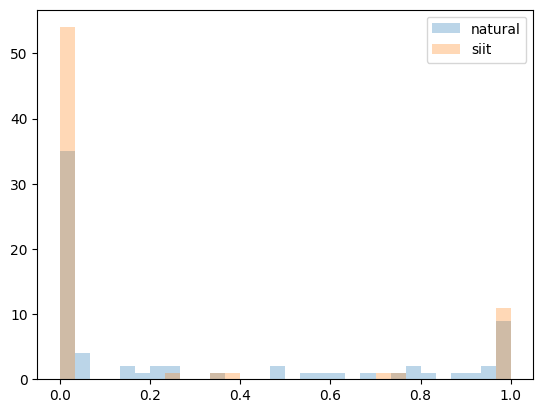

In [18]:
import matplotlib.pyplot as plt
n_resample_ablate_effect = []
s_resample_ablate_effect = []
i_resample_ablate_effect = []

for case, case_stats in all_stats.items():
    siit_df = case_stats["siit"]
    natural_df = case_stats["natural"]
    iit_df = case_stats["iit"]
    n_resample_ablate_effect.extend(natural_df["resample_ablate_effect"])
    s_resample_ablate_effect.extend(siit_df["resample_ablate_effect"])
    i_resample_ablate_effect.extend(iit_df["resample_ablate_effect"])

plt.hist(n_resample_ablate_effect, bins=30, alpha=0.3, label="natural")
plt.hist(s_resample_ablate_effect, bins=30, alpha=0.3, label="siit")
# plt.hist(i_resample_ablate_effect, bins=20, alpha=0.2, label="iit")
plt.legend()
pass

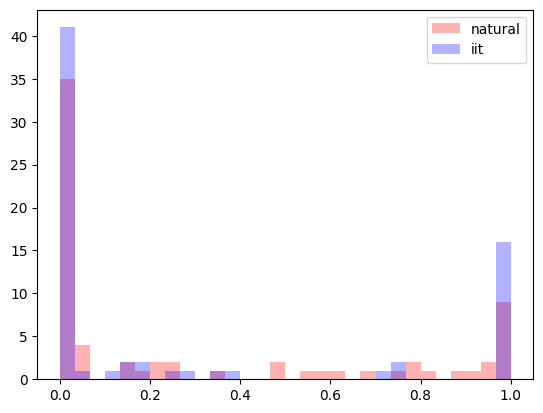

In [16]:
plt.hist(n_resample_ablate_effect, bins=30, alpha=0.3, label="natural", color="red")
plt.hist(i_resample_ablate_effect, bins=30, alpha=0.3, label="iit", color="blue")
plt.legend()

In [167]:
plt.rcParams.update({'font.size': 17})
plt.rcParams.update({'axes.labelsize': 18})
plt.rcParams.update({'axes.titlesize': 18})
plt.rcParams.update({'xtick.labelsize': 17})
plt.rcParams.update({'ytick.labelsize': 16})

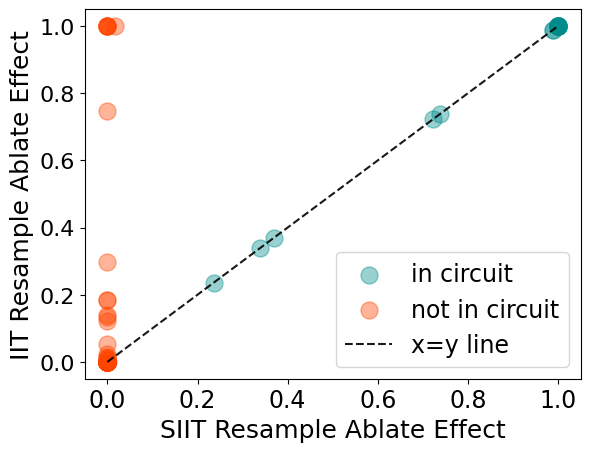

In [67]:
iit_resample_ablate_effect = []
siit_resample_ablate_effect = []
in_circuit = []

for case, case_stats in all_stats.items():
    siit_df = case_stats["siit"]
    iit_df = case_stats["iit"]
    nodes = set(siit_df["node"]) & set(iit_df["node"])
    for node in nodes:
        siit_resample_ablate_effect.append(siit_df[siit_df["node"] == node]["resample_ablate_effect"].values[0])
        in_circuit_val = siit_df[siit_df["node"] == node]["status"].values[0] == "in_circuit"
        if siit_df[siit_df["node"] == node]["resample_ablate_effect"].values[0] == 0 and in_circuit_val and case == "8": # the only constant node (this should be removed from the gt, but for now, a hacky fix)
            in_circuit_val = False
        if iit_df[iit_df["node"] == node]["resample_ablate_effect"].values[0] == 0 and in_circuit_val and case == "3":
            # the head index was changed for this case in the corr when training SIIT models. FFS. 
            iit_resample_ablate_effect.append(1.0)
        else:
            iit_resample_ablate_effect.append(iit_df[iit_df["node"] == node]["resample_ablate_effect"].values[0])
        
        in_circuit.append(in_circuit_val)


siit_ra_eff_in_circuit = [x for x, y in zip(siit_resample_ablate_effect, in_circuit) if y]
iit_ra_eff_in_circuit = [x for x, y in zip(iit_resample_ablate_effect, in_circuit) if y]
siit_ra_eff_not_in_circuit = [x for x, y in zip(siit_resample_ablate_effect, in_circuit) if not y]
iit_ra_eff_not_in_circuit = [x for x, y in zip(iit_resample_ablate_effect, in_circuit) if not y]
# scatter plot
plt.scatter(
    siit_ra_eff_in_circuit, 
    iit_ra_eff_in_circuit, 
    alpha=0.4,
    color="darkcyan",
    # marker size
    s=150,
    label="in circuit"
)
plt.scatter(
    siit_ra_eff_not_in_circuit, 
    iit_ra_eff_not_in_circuit, 
    alpha=0.4,
    color="orangered",
    # marker size
    s=150,
    label="not in circuit"
)


# add diagonal line
plt.plot([0, 1], [0, 1], color="black", linestyle="--", alpha=0.9, label="x=y line")
plt.legend()
plt.xlabel("SIIT Resample Ablate Effect")
plt.ylabel("IIT Resample Ablate Effect")

plt.savefig("plots/iit_vs_siit_resample_ablate_effect.pdf", bbox_inches="tight")
    

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/plotting.py:325: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/plotting.py:325: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/plotting.py:325: FutureWarning: The behavior of DataFrame concatenati

Run 19 does not have not_in_circuit
Run 19 does not have not_in_circuit


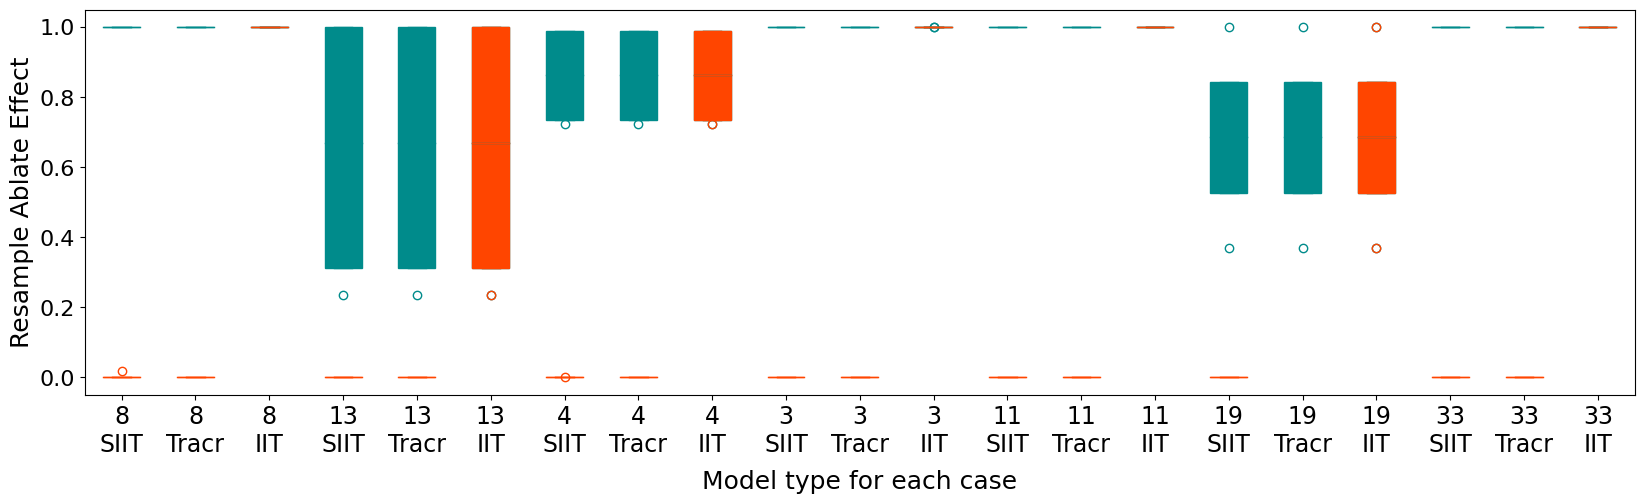

In [183]:
from interp_utils.node_stats.plotting import plot_results_in_box_plot, make_combined_df_from_all_stats

siit_radf, tracr_radf, iit_radf = make_combined_df_from_all_stats(all_stats, tracr_stats)

plot_results_in_box_plot(siit_radf, tracr_radf, iit_radf, normalize_by_runs=False, figsize=(20, 5))
plt.savefig("plots/iit_vs_siit_resample_ablate_effect_box_plot.pdf", bbox_inches="tight")

In [ ]:
from interp_utils.node_stats.plotting import make_dict_from_stats, make_df_from_stats
siit_all_df = make_df_from_stats(make_dict_from_stats(all_stats, "siit"))
for row in siit_all_df.iterrows():
        if row[1]["node"] == "blocks.0.attn.hook_result, head  0" and row[1]["status"] == "in_circuit" and row[1]["run"] == "8":
            print("Removing case 8 constant node for siit_all_df")
            siit_all_df.loc[row[0], "status"] = "not_in_circuit"

siit_all_df

In [326]:
siit_all_df.to_csv("interp_results/siit_node_stats_all_cases.csv")

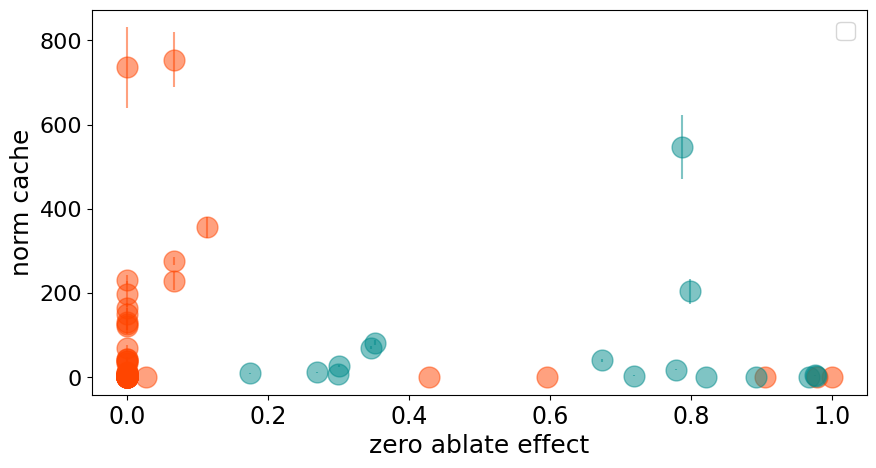

In [319]:
from interp_utils.node_stats.plotting import plot_all_df

plot_all_df(siit_all_df, 
            "zero_ablate_effect", 
            "norm_cache", 
            "status", "", y_err="norm_std")

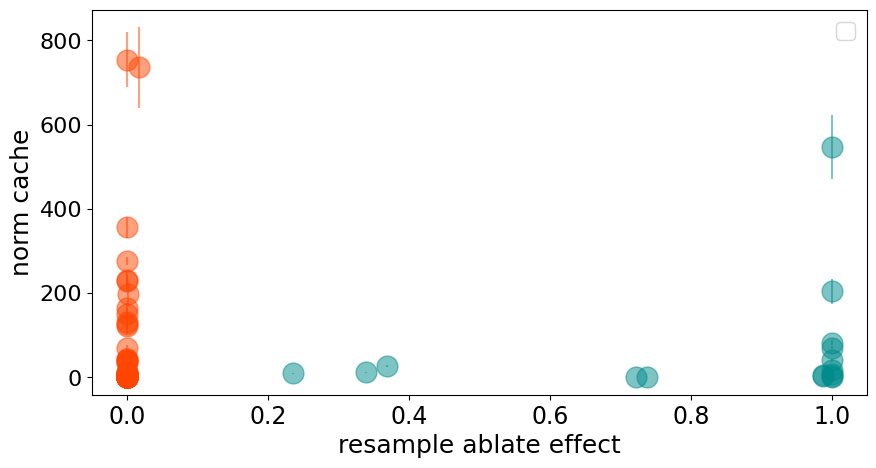

In [320]:
plot_all_df(siit_all_df, 
            "resample_ablate_effect", 
            "norm_cache", 
            "status", "", y_err="norm_std")

In [ ]:
# pd.read_csv("interp_results")

In [316]:
# plot_all_df(siit_all_df, 
#             "resample_ablate_effect", 
#             "grad_norm", 
#             "status", "", y_err=None,
#             y_log=True, 
#             x_log=False)

In [329]:
import pickle
pickle.dump(all_stats, open("interp_results/all_stats.pkl", "wb"))
pickle.dump(tracr_stats, open("interp_results/tracr_stats.pkl", "wb"))
pickle.dump(all_stats_kl, open("interp_results/all_stats_kl.pkl", "wb"))
pickle.dump(tracr_stats_kl, open("interp_results/tracr_stats_kl.pkl", "wb"))

In [189]:
# kl stats
all_stats_kl = make_all_stats(kl=True)
tracr_stats_kl = get_tracr_stats(all_stats_kl, kl=True)

Created temporary directory at /var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/tmpup3vdk7i
Moving model to device:  cpu
{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pre': HookPoint(), 'blocks.0.hook_resid_mid': HookPoint(), 'blocks.0.hook_resid_post': HookPoint(), 'blocks.1.attn.hook_k': HookPoint(), 'blocks.1.attn.hook_q': HookPoint(), 'b

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entry, index=[0])], axis=0, ignore_index=True)
100%|██████████| 8/8 [00:00<00:00, 60.32it/s]
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entry

Created temporary directory at /var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/tmpbzpkh6wl
Moving model to device:  cpu
{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pre': HookPoint(), 'blocks.0.hook_resid_mid': HookPoint(), 'blocks.0.hook_resid_post': HookPoint(), 'blocks.1.attn.hook_k': HookPoint(), 'blocks.1.attn.hook_q': HookPoint(), 'b

Moving model to device:  cpu
{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pre': HookPoint(), 'blocks.0.hook_resid_mid': HookPoint(), 'blocks.0.hook_resid_post': HookPoint(), 'blocks.1.attn.hook_k': HookPoint(), 'blocks.1.attn.hook_q': HookPoint(), 'blocks.1.attn.hook_v': HookPoint(), 'blocks.1.attn.hook_z': HookPoint(), 'blocks.1.attn.hook_

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entry, index=[0])], axis=0, ignore_index=True)
100%|██████████| 8/8 [00:00<00:00, 22.77it/s]
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entry

Created temporary directory at /var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/tmp58631go2
Failed to load 18
Could not find SIIT model with weights 100 for case 18 in wandb
Created temporary directory at /var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/tmpxrtcbbe_
Moving model to device:  cpu
{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pr

Moving model to device:  cpu
{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pre': HookPoint(), 'blocks.0.hook_resid_mid': HookPoint(), 'blocks.0.hook_resid_post': HookPoint()}
dict_keys([TracrHLNode(name: blocks.0.attn.hook_result,
 label: shift_by(1)_2,
 classes: 0,
 index: [:, :, 0, :]
), TracrHLNode(name: blocks.0.mlp.hook_post,
 label: se

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entry, index=[0])], axis=0, ignore_index=True)
100%|██████████| 8/8 [00:00<00:00, 23.12it/s]
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entry

Created temporary directory at /var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/tmpdl8gzzf_
Moving model to device:  cpu
{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pre': HookPoint(), 'blocks.0.hook_resid_mid': HookPoint(), 'blocks.0.hook_resid_post': HookPoint()}
dict_keys([TracrHLNode(name: blocks.0.mlp.hook_post,
 label: map_1,
 classes

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entry, index=[0])], axis=0, ignore_index=True)


Moving model to device:  cpu
{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pre': HookPoint(), 'blocks.0.hook_resid_mid': HookPoint(), 'blocks.0.hook_resid_post': HookPoint()}
dict_keys([TracrHLNode(name: blocks.0.mlp.hook_post,
 label: map_1,
 classes: 0,
 index: [:]
)])


100%|██████████| 8/8 [00:00<00:00, 97.43it/s]
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entry, index=[0])], axis=0, ignore_index=True)
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entry

Created temporary directory at /var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/tmp6pfj_lbk
Failed to load 34
Could not find SIIT model with weights 100 for case 34 in wandb
Created temporary directory at /var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/tmp_hpffbvf
Failed to load 35
Could not find SIIT model with weights 100 for case 35 in wandb
Created temporary directory at /var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/tmpcysnis6k
Failed to load 36
Could not find SIIT model with weights 100 for case 36 in wandb
Created temporary directory at /var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/tmpbc7sdcy_
Failed to load 37
Could not find SIIT model with weights 100 for case 37 in wandb
Created temporary directory at /var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/tmpttczhfvt
Moving model to device:  cpu
{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.att

Moving model to device:  cpu
{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pre': HookPoint(), 'blocks.0.hook_resid_mid': HookPoint(), 'blocks.0.hook_resid_post': HookPoint()}
dict_keys([TracrHLNode(name: blocks.0.attn.hook_result,
 label: shift_by(-1)_2,
 classes: 0,
 index: [:, :, 0, :]
), TracrHLNode(name: blocks.0.mlp.hook_post,
 label: s

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entry, index=[0])], axis=0, ignore_index=True)
100%|██████████| 8/8 [00:00<00:00, 30.41it/s]
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entry

{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pre': HookPoint(), 'blocks.0.hook_resid_mid': HookPoint(), 'blocks.0.hook_resid_post': HookPoint(), 'blocks.1.attn.hook_k': HookPoint(), 'blocks.1.attn.hook_q': HookPoint(), 'blocks.1.attn.hook_v': HookPoint(), 'blocks.1.attn.hook_z': HookPoint(), 'blocks.1.attn.hook_attn_scores': HookPoint(), 'b

100%|██████████| 8/8 [00:00<00:00, 70.84it/s]
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entry, index=[0])], axis=0, ignore_index=True)


{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pre': HookPoint(), 'blocks.0.hook_resid_mid': HookPoint(), 'blocks.0.hook_resid_post': HookPoint(), 'blocks.1.attn.hook_k': HookPoint(), 'blocks.1.attn.hook_q': HookPoint(), 'blocks.1.attn.hook_v': HookPoint(), 'blocks.1.attn.hook_z': HookPoint(), 'blocks.1.attn.hook_attn_scores': HookPoint(), 'b

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entry, index=[0])], axis=0, ignore_index=True)
100%|██████████| 8/8 [00:00<00:00, 37.12it/s]
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entry

{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pre': HookPoint(), 'blocks.0.hook_resid_mid': HookPoint(), 'blocks.0.hook_resid_post': HookPoint()}
dict_keys([TracrHLNode(name: blocks.0.attn.hook_result,
 label: shift_by(1)_2,
 classes: 0,
 index: [:, :, 0, :]
), TracrHLNode(name: blocks.0.mlp.hook_post,
 label: sequential_duplicate_removal_1,

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entry, index=[0])], axis=0, ignore_index=True)
100%|██████████| 8/8 [00:00<00:00, 56.82it/s]
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entry

{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pre': HookPoint(), 'blocks.0.hook_resid_mid': HookPoint(), 'blocks.0.hook_resid_post': HookPoint()}
dict_keys([TracrHLNode(name: blocks.0.mlp.hook_post,
 label: map_1,
 classes: 0,
 index: [:]
)])


100%|██████████| 8/8 [00:00<00:00, 174.71it/s]
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entry, index=[0])], axis=0, ignore_index=True)


{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pre': HookPoint(), 'blocks.0.hook_resid_mid': HookPoint(), 'blocks.0.hook_resid_post': HookPoint()}
dict_keys([TracrHLNode(name: blocks.0.attn.hook_result,
 label: shift_by(-1)_2,
 classes: 0,
 index: [:, :, 0, :]
), TracrHLNode(name: blocks.0.mlp.hook_post,
 label: sequence_map_1,
 classes: 0,
 

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entry, index=[0])], axis=0, ignore_index=True)
100%|██████████| 8/8 [00:00<00:00, 116.59it/s]
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/stats_to_df.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(entr

(dict_keys(['11', '13', '19', '33', '8']),
 dict_keys(['11', '13', '19', '33', '8']))

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/plotting.py:328: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table,
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/plotting.py:328: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table,
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/node_stats/plotting.py:328: FutureWarning: The behavior of Dat

Removing case 8 constant node for siit
Removing case 8 constant node for iit
Removing case 8 constant node for tracr
Run 19 does not have not_in_circuit
Run 19 does not have not_in_circuit


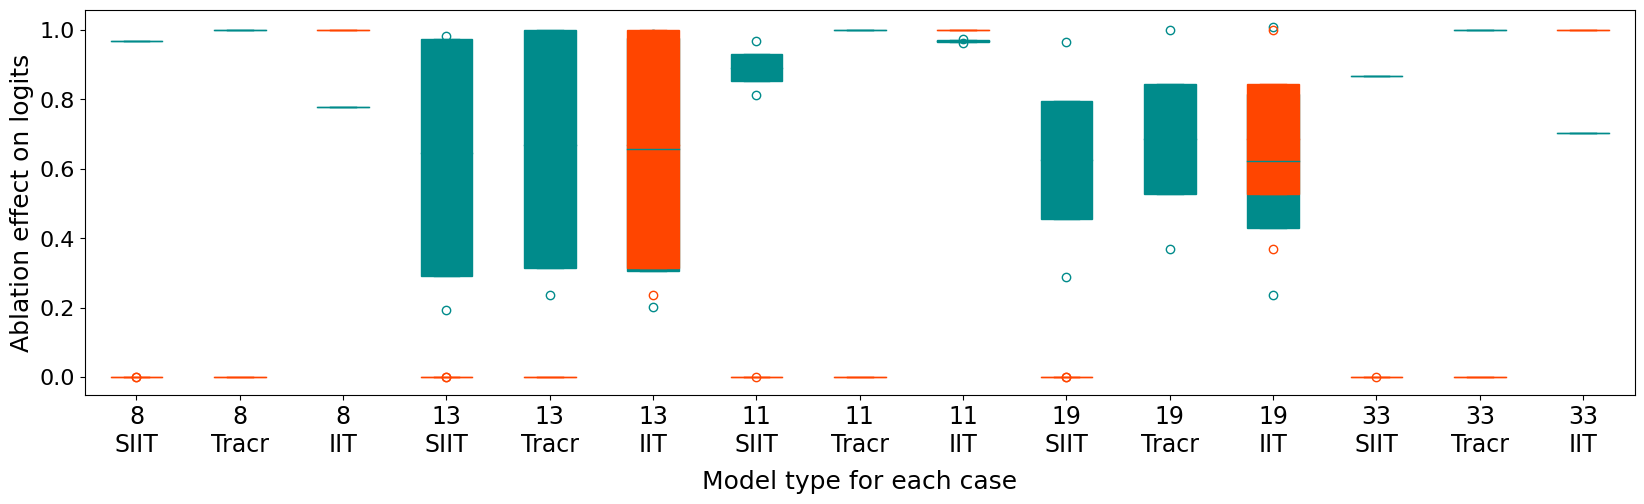

In [209]:
from interp_utils.node_stats.plotting import plot_results_in_box_plot, make_combined_df_from_all_stats
siit_radf_kl, tracr_radf_kl, iit_radf_kl = make_combined_df_from_all_stats(all_stats_kl, tracr_stats_kl)

plot_results_in_box_plot(siit_radf_kl, tracr_radf_kl, iit_radf_kl, normalize_by_runs=False, figsize=(20, 5), kl_divergence=True)
plt.savefig("plots/iit_vs_siit_kl_resample_ablate_effect_box_plot.pdf", bbox_inches="tight")

### Rough

In [ ]:
# from iit.utils.node_picker import get_all_individual_nodes_in_circuit, find_ll_node_by_name
# from interp_utils.resample_ablate.collect_cache import collect_activations, collect_pca_directions

# # collect activations
# activations = collect_activations(model_pair, loader)
# pca_dirs = collect_pca_directions(activations)
# nodes = get_all_individual_nodes_in_circuit(model, hl_ll_corr)

# # plot cosine similarity matrix for all nodes
# import numpy as np

# def get_cosine_similarity_matrix(pca_dirs, nodes_in_circuit, n_components=2):
#     all_components_stacked = []
#     for i in n_components:
#         component_stacked = np.vstack([pca_dirs[node][i] for node in nodes_in_circuit])
#         all_components_stacked.append(component_stacked)
    
#     all_components_stacked = np.stack(all_components_stacked, axis=0)
#     # now each component is a vector
